
# Kelompok Argozt
- **Ziyad Fathir Al Biaroza** - 103012300455
- **I Gede Krisna Ganesha Widhiarta** - 103012300088
- **I Putu Justine Budi Wijaya** - 103012300361

Pengelolaan sampah yang efektif memerlukan proses pemilahan yang tepat sesuai dengan jenisnya. Namun, proses pemilahan tersebut masih sering dilakukan secara manual sehingga kurang efisien. Oleh karena itu, proyek ini bertujuan untuk menerapkan metode kecerdasan artifisial dalam melakukan klasifikasi jenis sampah berdasarkan teks.

Pada proyek ini digunakan metode Naive Bayes yang diimplementasikan secara manual tanpa memanfaatkan library pembelajaran mesin siap pakai. Proses yang dilakukan meliputi pengambilan dataset, text preprocessing, ekstraksi fitur berbasis n-gram, perhitungan probabilitas, serta evaluasi performa model menggunakan metrik akurasi dan F1-Score. Melalui pendekatan ini, diharapkan sistem mampu mengklasifikasikan jenis sampah secara otomatis dan memberikan pemahaman mengenai penerapan Naive Bayes pada permasalahan klasifikasi teks.

1. Import Library

In [253]:
import pandas as pd #Untuk kelola dataset tabular
import numpy as np #Untuk komputasi numerik
import math #Untuk fungsi matematika
import re #Untuk pemrosesan teks
import json #Untuk manipulasi data JSON
import matplotlib.pyplot as plt #Untuk visualisasi data
from collections import defaultdict #Untuk struktur data dictionary dengan nilai default
import sys
from datasets import load_dataset #Untuk memuat dataset dari Hugging Face Datasets
import random #Untuk operasi acak
import multiprocessing as mp  #Untuk pemrosesan paralel


2. Load Dataset

Pada tahap ini berfungsi untuk mengambil dataset waste-classification-v3 dari HuggingFace dan mengubah format menjadi pandas DataFrame

In [254]:
ds = load_dataset("thomasavare/waste-classification-v3") #Dataset ini bertipe DatasetDict
train_df = ds["train"].to_pandas() #Mengubah dataset train menjadi dataframe pandas
validation_df = ds["validation"].to_pandas() #Mengubah dataset validation menjadi dataframe pandas
test_df = ds["test"].to_pandas() #Mengubah dataset test menjadi dataframe pandas

print("Train set size:", train_df.shape)
train_df.head()
print("\nValidation set size:", validation_df.shape)
validation_df.head()
print("\nTest set size:", test_df.shape)
test_df.head()

Train set size: (16146, 4)

Validation set size: (5382, 4)

Test set size: (5382, 4)


,Unnamed: 0,Phrase,Class,Class_index
0,19639,Where do I put this water cap ?,PLASTIC CAP,31.0
1,18078,Where do I have to throw a pizza box ?,PIZZA BOX,27.0
2,21460,"Hey, I'm going to throw this latex gloves",PLASTIC GLOVES,35.0
3,7798,I would like to throw this pc charger,LAPTOP CHARGER,13.0
4,6267,"I have a perrier glass bottle to throw, where ...",GLASS BOTTLE,11.0


3. Exploratory Data Analysis

Tahap ini berguna untuk melihat dan memahami dataset. EDA menjadi bagian penting pada proyek ini karena dataset yang berbasis teks, memiliki banyak kelas dan akan digunakan untuk Naive Bayes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16146 entries, 0 to 16145
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16146 non-null  int64  
 1   Phrase       16146 non-null  object 
 2   Class        16146 non-null  object 
 3   Class_index  16146 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 504.7+ KB


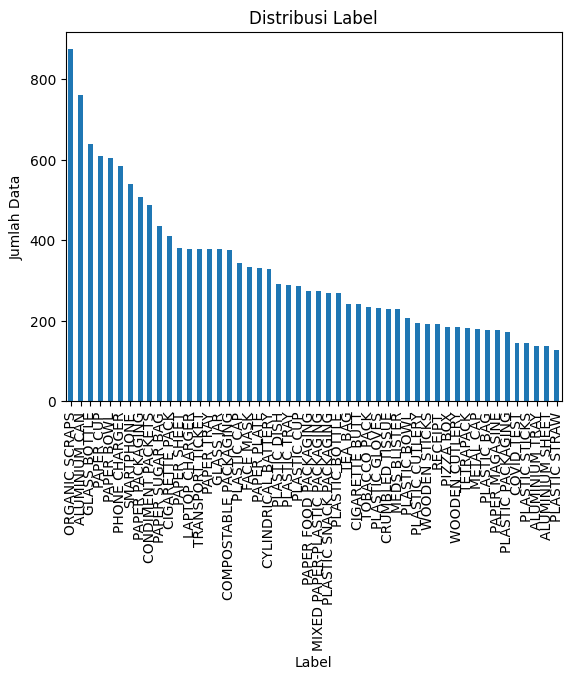

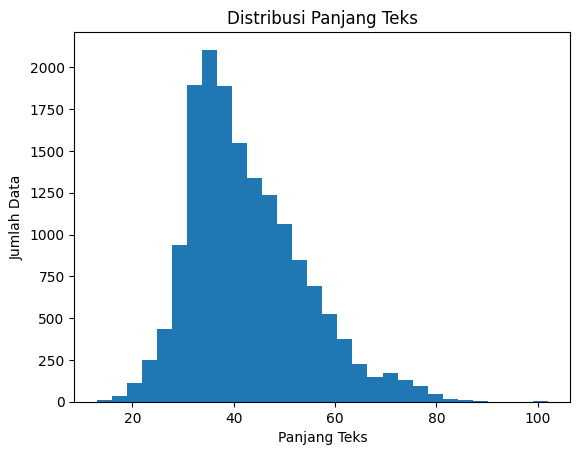

In [255]:
#Struktur kolom
train_df.info()

#Distribusi Label
train_df['Class'].value_counts()

#Visualisasi Distribusi Label
train_df['Class'].value_counts().plot(kind='bar')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.show()

#Melihat teks panjang atau tidak
train_df['text_length'] = train_df['Phrase'].apply(len)
train_df['text_length'].describe()

#Visualisasi Panjang Teks
plt.hist(train_df['text_length'], bins=30) 
plt.title("Distribusi Panjang Teks")
plt.xlabel("Panjang Teks")
plt.ylabel("Jumlah Data")
plt.show()

4. Text Preprocessing

Pada tahap ini merupakan proses membersihkan teks agar konsisten. Ini penting karena konsep Naive Bayes bekerja dengan menghitung frekuensi kata dan menghitung probabilitas kemunculan kata tiap kelas. Jika tidak dibersihkan dapat terjadi duplikasi data pada makna yang sama.

In [256]:
def preprocess_text(text):
    #Lowercase
    text = text.lower()
    #Hapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)
    #Hapus spasi ekstra
    text = text.strip()
    return text

def tokenize_text(text):
    return text.split()

#Lowercase
train_df['Phrase'] = train_df['Phrase'].str.lower()

#Hapus tanda baca
train_df['Phrase'] = train_df['Phrase'].str.replace(r'[^\w\s]', '', regex=True)

#Hapus spasi ekstra
train_df['Phrase'] = train_df['Phrase'].str.strip()

#Tokenisasi
train_df['tokens'] = train_df['Phrase'].str.split()

#Keluaran hasil preprocessing
train_df[['Phrase', 'tokens']].head()

,Phrase,tokens
0,i have this wooden fork where should i throw it,"[i, have, this, wooden, fork, where, should, i..."
1,excuse me can you help me i dont know where t...,"[excuse, me, can, you, help, me, i, dont, know..."
2,where can i throw my sony phone,"[where, can, i, throw, my, sony, phone]"
3,what bin is best suited for my biodegradable p...,"[what, bin, is, best, suited, for, my, biodegr..."
4,hey im going to throw this plastic containers,"[hey, im, going, to, throw, this, plastic, con..."


5. Feature Extraction (N-gram)

Pada tahap ini data mentah diubah menjadi fitur numerik yang bisa diproses oleh algoritma. Pada implementasi proyek ini hanya digunakan N(1) = Unigram dan N(2) Bigram, kombinasi keduanya telah cukup untuk menangkap makna teks agar dapat mencapai titik optimal antara performansi dan kompleksitas fitur.

In [257]:
#Fungsi untuk menghasilkan n-grams
def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = ' '.join(tokens[i:i+n])
        ngrams.append(ngram)
    return ngrams

#Menggabungkan unigram dan bigram
def extract_features(tokens):
    unigrams = generate_ngrams(tokens, 1)
    bigrams = generate_ngrams(tokens, 2)
    return unigrams + bigrams

#Aplikasikan ke seluruh dataset
train_df['features'] = train_df['tokens'].apply(extract_features)

#Tampilan hasil ekstraksi fitur
train_df[['Phrase', 'features']].head()

,Phrase,features
0,i have this wooden fork where should i throw it,"[i, have, this, wooden, fork, where, should, i..."
1,excuse me can you help me i dont know where t...,"[excuse, me, can, you, help, me, i, dont, know..."
2,where can i throw my sony phone,"[where, can, i, throw, my, sony, phone, where ..."
3,what bin is best suited for my biodegradable p...,"[what, bin, is, best, suited, for, my, biodegr..."
4,hey im going to throw this plastic containers,"[hey, im, going, to, throw, this, plastic, con..."


6. Membangun Vocabulary (Dictionary)

Membangun dictionary untuk klasifikasi menggunakan hasil dataset training

In [258]:
def build_vocabulary(train_df):
    vocab = set()
    for features in train_df['features']:
        for token in features:
            vocab.add(token)
    return vocab
vocabulary = build_vocabulary(train_df)
print("Ukuran Vocabulary:", len(vocabulary))

Ukuran Vocabulary: 2316


(Tambahan) Perhitungan IDF (Inverse Document Frequency) Global

In [259]:
def compute_idf(train_df, vocabulary):
    N = len(train_df)
    idf = {}

    #Menghitung banyaknya dokumen yang mengandung setiap token
    doc_freq = defaultdict(int)
    for features in train_df['features']:
        unique_tokens = set(features)
        for token in unique_tokens:
            doc_freq[token] += 1

    #Menghitung IDF untuk setiap token
    for token in vocabulary:
        idf[token] = math.log(N / (1 + doc_freq[token]))  # Menambahkan 1 untuk menghindari pembagian dengan nol
    return idf

idf_scores = compute_idf(train_df, vocabulary)

7. Likelihood Probability

Dengan membuat token statistik, kita akan mendapatkan token_counts, total_tokens_per_class, doc_count_per_class

In [260]:
def build_token_statistics(train_df):
    #Jumlah Token per Kelas dan Total Token per Kelas
    token_counts = defaultdict(lambda: defaultdict(int))
    #Jumlah total token per kelas
    total_tokens_per_class = defaultdict(int)
    #Jumlah dokumen per kelas
    doc_count_per_class = defaultdict(int)

    for _, row in train_df.iterrows():
        label = row['Class']
        doc_count_per_class[label] += 1
        features = row['features']

        for token in features:
            token_counts[label][token] += 1
            total_tokens_per_class[label] += 1

    return token_counts, total_tokens_per_class, doc_count_per_class

token_counts, total_tokens_per_class, doc_count_per_class = build_token_statistics(train_df)

#Precomputed Likelihood TF-IDF
def precompute_likelihoods_tfidf(train_df, idf_scores, vocabulary, alpha=1):
    tfidf_sums_per_class = defaultdict(lambda: defaultdict(float))
    total_tfidf_per_class = defaultdict(float)
    class_labels = train_df['Class'].unique()
    vocab_size = len(vocabulary)

    #Hitung TF-IDF tiap kata di tiap dokumen
    for _, row in train_df.iterrows():
        label = row['Class']
        features = row['features']

        #Hitung TF di dokumen
        counts = defaultdict(int)
        for token in features:
            counts[token] += 1

        for token, count in counts.items():
            tfidf = count * idf_scores.get(token, 0)
            tfidf_sums_per_class[label][token] += tfidf
            total_tfidf_per_class[label] += tfidf

    #Normalisasi jadi probabilitas dengan Laplace Smoothing
    likelihoods = defaultdict(lambda: defaultdict(float))
    for label in class_labels:
        for token in vocabulary:
            tfidf_sum = tfidf_sums_per_class[label].get(token, 0)
            #Rumus Naive Bayes mofifikasi dengan TF-IDF dan Laplace Smoothing
            likelihoods[label][token] = (tfidf_sum + alpha) / (total_tfidf_per_class[label] + (alpha * vocab_size))

    return likelihoods

#On-the-fly Likelihood Calculation dengan Laplace Smoothing (Low Memory Usage)
def likelihood(token, label, token_counts, total_tokens_per_class, vocabulary, alpha=1):
    vocab_size = len(vocabulary)
    token_count = token_counts[label].get(token, 0)
    return (token_count + alpha) / (total_tokens_per_class[label] + (alpha * vocab_size))

8. Prior Probability

In [261]:
def compute_prior(doc_count_per_class):
    total_docs = sum(doc_count_per_class.values())
    prior = {}
    for label, count in doc_count_per_class.items():
        prior[label] = count / total_docs
    return prior

class_priors = compute_prior(doc_count_per_class)
print("Prior Kelas:", class_priors)

Prior Kelas: {'WOODEN CUTLERY': 0.011457946240554935, 'MIXED PAPER-PLASTIC PACKAGING': 0.016908212560386472, 'SMARTPHONE': 0.033382881208968165, 'PAPER PACKAGING': 0.03146290102811842, 'PLASTIC DISH': 0.018023039762170196, 'GLASS BOTTLE': 0.039576365663322184, 'PAPER PLATE': 0.020438498699368264, 'CRUMBLED TISSUE': 0.014245014245014245, 'CIGARETTE PACK': 0.02539328626285148, 'LAPTOP CHARGER': 0.023473306082001735, 'PLASTIC STICKS': 0.008918617614269788, 'PLASTIC BOWL': 0.01275857797596928, 'ORGANIC SCRAPS': 0.05406911928651059, 'TOBACCO PACK': 0.014554688467731947, 'PAPER TRAY': 0.023349436392914653, 'PLASTIC CUTLERY': 0.012015359841446797, 'PAPER SHEET': 0.023535240926545273, 'TRANSPORT TICKET': 0.023473306082001735, 'PHONE CHARGER': 0.03610801436888393, 'PLASTIC GLOVES': 0.014368883934101325, 'PAPER BOWL': 0.03747058094884182, 'COVID TEST': 0.008980552458813329, 'PAPER CUP': 0.03765638548247244, 'PLASTIC BOTTLE': 0.01659853833766877, 'ALUMINIUM CAN': 0.047132416697634086, 'PLASTIC CU

9. Prediksi

In [262]:
#On-the-fly Likelihood/Prediction Calculation
def predict_onthefly(features, class_priors, likelihoods, total_tokens_per_class, vocabulary, alpha=1):
    class_scores = {}

    for label in class_priors:
        log_prob = math.log(class_priors[label])
        for token in features:
            token_likelihood = likelihood(token, label, likelihoods, total_tokens_per_class, vocabulary, alpha)
            log_prob += math.log(token_likelihood)
        class_scores[label] = log_prob
    predicted_label = max(class_scores, key=class_scores.get)
    return predicted_label, class_scores

#Precomputed Likelihood Prediction TF-IDF
def predict_precomputed_tfidf(features, class_priors, likelihoods):
    class_scores = {}

    for label in class_priors:
        log_prob = math.log(class_priors[label])
        for token in features:
            if token in likelihoods[label]:
                log_prob += math.log(likelihoods[label][token])
        class_scores[label] = log_prob
        
    return max(class_scores, key=class_scores.get), class_scores

def predict_phrase_onthefly(phrase, class_priors, likelihoods, total_tokens_per_class, vocabulary, alpha=1):
    #Preprocessing
    clean = preprocess_text(phrase)
    tokens = tokenize_text(clean)
    features = extract_features(tokens)
    return predict_onthefly(features, class_priors, likelihoods, total_tokens_per_class, vocabulary, alpha)

def predict_phrase_precomputed_tfidf(phrase, class_priors, likelihoods):
    #Preprocessing
    clean = preprocess_text(phrase)
    tokens = tokenize_text(clean)
    features = extract_features(tokens)
    return predict_precomputed_tfidf(features, class_priors, likelihoods)

10. Demo Predict

In [263]:
phrase = "soda can is my favorite drink"

# Hitung IDF Scores
idf_scores = compute_idf(train_df, vocabulary)

#Hitung model TF-IDF
tfidf_model = precompute_likelihoods_tfidf(train_df, idf_scores, vocabulary)

#predict with on-the-fly likelihood calculation
predicted_label_onthefly, class_score = predict_phrase_onthefly(phrase, class_priors, token_counts, total_tokens_per_class, vocabulary)

print("\nInput Phrase:", phrase)
print("------------------------------------------------")
print("\nPredicted Label OntheFly:", predicted_label_onthefly)
print("------------------------------------------------")

#Predict with precomputed TF-IDF
predicted_label_tfidf, class_scores = predict_phrase_precomputed_tfidf(phrase, class_priors, tfidf_model)
print("\nPredicted Label Precomputed TF-IDF:", predicted_label_tfidf)
print("\nClass Scores Precomputed TF-IDF:", class_scores)


Input Phrase: soda can is my favorite drink
------------------------------------------------

Predicted Label OntheFly: RECEIPT
------------------------------------------------

Predicted Label Precomputed TF-IDF: ALUMINIUM CAN

Class Scores Precomputed TF-IDF: {'WOODEN CUTLERY': -28.218209070855902, 'MIXED PAPER-PLASTIC PACKAGING': -27.899982525471245, 'SMARTPHONE': -25.79949783125275, 'PAPER PACKAGING': -25.897825675215678, 'PLASTIC DISH': -26.94002224265273, 'GLASS BOTTLE': -25.94332724979202, 'PAPER PLATE': -26.275044747325428, 'CRUMBLED TISSUE': -27.36368558456023, 'CIGARETTE PACK': -26.148084010551262, 'LAPTOP CHARGER': -26.035340600358968, 'PLASTIC STICKS': -30.880784342179954, 'PLASTIC BOWL': -26.493668569140855, 'ORGANIC SCRAPS': -24.955322635616007, 'TOBACCO PACK': -27.44195335215113, 'PAPER TRAY': -26.05510099768579, 'PLASTIC CUTLERY': -26.89598060956007, 'PAPER SHEET': -26.042440500037248, 'TRANSPORT TICKET': -26.831560282496593, 'PHONE CHARGER': -26.27573296894099, 'PLAST

11. Evaluasi (Accuracy, F1, dst)

In [264]:
def confusion_matrix(true_labels, predicted_labels, class_labels):
    matrix = {l:{k:0 for k in class_labels} for l in class_labels}

    for true, pred in zip(true_labels, predicted_labels):
        matrix[true][pred] += 1

    return matrix

def accuracy(true_labels, predicted_labels):
    correct = sum(t == p for t, p in zip(true_labels, predicted_labels))
    return correct / len(true_labels)

#get memory usage size of a functions
def get_size(obj):
    return sys.getsizeof(obj)

12. Evaluasi dengan Predict Phrase dan Validation Dataset

In [265]:
# Definisikan label class
class_labels = train_df['Class'].unique().tolist()
true_labels = validation_df['Class'].tolist()

# Proses prediksi untuk model On-The-Fly dan Precomputed TF-IDF
print("Sedang mengevaluasi Model On-The-Fly...")
predicted_onthefly = []
for phrase in validation_df['Phrase']:
    label, _ = predict_phrase_onthefly(phrase, class_priors, token_counts, total_tokens_per_class, vocabulary)
    predicted_onthefly.append(label)

print("Sedang mengevaluasi Model Precomputed TF-IDF...")
predicted_precomputed = []
for phrase in validation_df['Phrase']:
    label, _ = predict_phrase_precomputed_tfidf(phrase, class_priors, tfidf_model)
    predicted_precomputed.append(label)

# Menggunakan fungsi confusion_matrix yang sudah Anda buat sebelumnya
confusion_mat_onthefly = confusion_matrix(true_labels, predicted_onthefly, class_labels)
confusion_mat_precomputed = confusion_matrix(true_labels, predicted_precomputed, class_labels)

# Menggunakan fungsi accuracy yang sudah Anda buat sebelumnya
accuracy_onthefly = accuracy(true_labels, predicted_onthefly)
accuracy_precomputed = accuracy(true_labels, predicted_precomputed)

# Definisikan get_full_metrics
def get_full_metrics(confusion_mat, class_labels):
    precision_list = []
    recall_list = []
    f1_list = []

    for label in class_labels:
        tp = confusion_mat[label][label]
        fp = sum(confusion_mat[l][label] for l in class_labels) - tp
        fn = sum(confusion_mat[label][l] for l in class_labels) - tp

        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0
        f = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        precision_list.append(p)
        recall_list.append(r)
        f1_list.append(f)

    #Rata-rata makro
    macro_p = sum(precision_list) / len(class_labels)
    macro_r = sum(recall_list) / len(class_labels)
    macro_f1 = sum(f1_list) / len(class_labels)

    return macro_p, macro_r, macro_f1

# Metrik macro untuk On-the-fly
macro_p_fly, macro_r_fly, macro_f1_fly = get_full_metrics(confusion_mat_onthefly, class_labels)

# Metrik macro untuk Precomputed TF-IDF
macro_p_pre, macro_r_pre, macro_f1_pre = get_full_metrics(confusion_mat_precomputed, class_labels)

# Hitung ukuran memori model
size_token_counts = get_size(token_counts)
size_likelihoods = get_size(tfidf_model)

# Print hasil evaluasi
print("\n" + "="*50)
print("HASIL EVALUASI MODEL: ON-THE-FLY (COUNT)")
print("="*50)
print(f"Accuracy:        {accuracy_onthefly:.4f}")
print(f"Macro Precision: {macro_p_fly:.4f}")
print(f"Macro Recall:    {macro_r_fly:.4f}")
print(f"Macro F1 Score:  {macro_f1_fly:.4f}")

print("\n" + "="*50)
print("HASIL EVALUASI MODEL: PRECOMPUTED (TF-IDF)")
print("="*50)
print(f"Accuracy:        {accuracy_precomputed:.4f}")
print(f"Macro Precision: {macro_p_pre:.4f}")
print(f"Macro Recall:    {macro_r_pre:.4f}")
print(f"Macro F1 Score:  {macro_f1_pre:.4f}")

print("\n" + "="*50)
print("PERBANDINGAN MEMORI")
print("="*50)
print(f"Memori Token Counts (Dictionary): {size_token_counts} bytes")
print(f"Memori TF-IDF Model (Likelihood): {size_likelihoods} bytes")
print("="*50)

Sedang mengevaluasi Model On-The-Fly...
Sedang mengevaluasi Model Precomputed TF-IDF...

HASIL EVALUASI MODEL: ON-THE-FLY (COUNT)
Accuracy:        0.9498
Macro Precision: 0.9595
Macro Recall:    0.9392
Macro F1 Score:  0.9469

HASIL EVALUASI MODEL: PRECOMPUTED (TF-IDF)
Accuracy:        0.9575
Macro Precision: 0.9582
Macro Recall:    0.9563
Macro F1 Score:  0.9570

PERBANDINGAN MEMORI
Memori Token Counts (Dictionary): 1592 bytes
Memori TF-IDF Model (Likelihood): 1592 bytes


13. Genetic Algorithm - Inisialisasi

In [266]:
# Variabel global untuk evaluator
TRAIN_TOKEN_COUNTS = None
TRAIN_TOTAL_TOKENS = None
TRAIN_DOC_COUNTS = None
VAL_DF = None
VOCAB_LIST = None
TOKEN_TO_INDEX = None
LABELS_LIST = None
IDF_SCORES_GLOBAL = None
SELECTION_THRESHOLD = 0.1

# Membangun statistik token dari dataframe (hanya training split)
def compute_stats_from_df(df):
    token_counts = defaultdict(lambda: defaultdict(int))  
    total_tokens_per_class = defaultdict(int)
    doc_count_per_class = defaultdict(int)
    vocab = set()

    for _, row in df.iterrows():
        label = row['Class']
        doc_count_per_class[label] += 1
        features = row['features']
        for token in features:
            token_counts[label][token] += 1
            total_tokens_per_class[label] += 1
            vocab.add(token)

    return token_counts, total_tokens_per_class, doc_count_per_class, sorted(vocab)

# Inisialisasi global variables
def evaluator_init(train_token_counts, train_total_tokens, train_doc_counts, val_df, vocab_list, selection_threshold, idf_scores):
    global TRAIN_TOKEN_COUNTS, TRAIN_TOTAL_TOKENS, TRAIN_DOC_COUNTS, VAL_DF, VOCAB_LIST, TOKEN_TO_INDEX, LABELS_LIST, SELECTION_THRESHOLD, IDF_SCORES_GLOBAL
    TRAIN_TOKEN_COUNTS = train_token_counts
    TRAIN_TOTAL_TOKENS = train_total_tokens
    TRAIN_DOC_COUNTS = train_doc_counts
    VAL_DF = val_df
    VOCAB_LIST = vocab_list
    TOKEN_TO_INDEX = {t: i for i, t in enumerate(VOCAB_LIST)}
    LABELS_LIST = list(TRAIN_TOKEN_COUNTS.keys())
    SELECTION_THRESHOLD = selection_threshold
    IDF_SCORES_GLOBAL = idf_scores

14. Genetic Algorthm - Evaluator GENOME

In [267]:
# Menghitung fitness dari satu genome.
def evaluate_genome(genome):
    global TRAIN_TOKEN_COUNTS, TRAIN_TOTAL_TOKENS, TRAIN_DOC_COUNTS, VAL_DF, VOCAB_LIST, TOKEN_TO_INDEX, LABELS_LIST, SELECTION_THRESHOLD, IDF_SCORES_GLOBAL

    weights, alpha = genome
    V_selected = int((weights > SELECTION_THRESHOLD).sum())

    if V_selected == 0:
        return 0.0

    # 1. Precompute Masked Totals dengan pengali IDF
    masked_total_tokens = {}
    for label in TRAIN_TOKEN_COUNTS:
        s = 0.0
        for i, token in enumerate(VOCAB_LIST):
            w = weights[i]
            if w <= SELECTION_THRESHOLD:
                continue
            c = TRAIN_TOKEN_COUNTS[label].get(token, 0)
            if c > 0:
                # INTEGRASI IDF: Bobot efektif adalah Count * IDF * GA_Weight
                idf = IDF_SCORES_GLOBAL.get(token, 0.0)
                s += c * idf * w
        masked_total_tokens[label] = s

    # 2. Compute Priors
    total_docs = sum(TRAIN_DOC_COUNTS.values())
    priors = {lbl: (TRAIN_DOC_COUNTS.get(lbl,0) / total_docs) if total_docs > 0 else 1/len(TRAIN_DOC_COUNTS) for lbl in TRAIN_DOC_COUNTS}

    # 3. Denominator per label
    denom_per_label = {lbl: masked_total_tokens[lbl] + (alpha * V_selected) for lbl in masked_total_tokens}

    correct = 0
    total = 0

    # 4. Loop Validasi
    for _, row in VAL_DF.iterrows():
        total += 1
        features = row['features']
        true_label = row['Class']
        
        best_label = None
        best_score = -float('inf')

        for label in LABELS_LIST:
            prior = priors.get(label, 0)
            if prior == 0: continue
            
            logp = math.log(prior + 1e-12)
            denom = denom_per_label[label] + 1e-12
            
            for token in features:
                idx = TOKEN_TO_INDEX.get(token)
                if idx is None: continue
                
                w = weights[idx]
                if w <= SELECTION_THRESHOLD: continue
                
                # INTEGRASI IDF: count * idf * w
                c = TRAIN_TOKEN_COUNTS[label].get(token, 0)
                idf = IDF_SCORES_GLOBAL.get(token, 0.0)
                
                prob = (c * idf * w + alpha) / denom
                logp += math.log(prob + 1e-12)

            if logp > best_score:
                best_score = logp
                best_label = label

        if (best_label if best_label is not None else random.choice(LABELS_LIST)) == true_label:
            correct += 1

    return correct / total

15. Genetic Algorithm - Prediction and Likelihoods Helper

In [268]:
def build_precomputed_likelihoods_from_weights(best_weights, best_alpha, train_token_counts, train_total_tokens, vocab_list, selection_threshold=0.1):
    V_selected = int((best_weights > selection_threshold).sum())
    vocab_size = V_selected
    likelihoods = defaultdict(dict)
    masked_total_tokens = {}

    for label in train_token_counts:
        s = 0.0
        for i, token in enumerate(vocab_list):
            w = best_weights[i]
            if w <= selection_threshold: continue
            c = train_token_counts[label].get(token, 0)
            s += c * w
        masked_total_tokens[label] = s

    for label in train_token_counts:
        for i, token in enumerate(vocab_list):
            w = best_weights[i]
            if w <= selection_threshold: continue
            token_count = train_token_counts[label].get(token, 0) * w
            denom = masked_total_tokens[label] + best_alpha * vocab_size
            likelihoods[label][token] = (token_count + best_alpha) / (denom + 1e-12)

    return likelihoods

def predict_precomputed_with_weights(features, class_priors, likelihoods):
    class_scores = {}
    for label in class_priors:
        log_prob = math.log(class_priors[label] + 1e-12)
        for token in features:
            token_likelihood = likelihoods[label].get(token, None)
            if token_likelihood is None: continue
            log_prob += math.log(token_likelihood + 1e-12)
        class_scores[label] = log_prob
    predicted_label = max(class_scores, key=class_scores.get)
    return predicted_label, class_scores

16. Genetic Algorithm - Main Fuction

In [269]:
# Function utama untuk genetic algorithm feature weight selection
def genetic_feature_weight_selection(train_df, val_df, idf_scores,
                                     pop_size, generations, crossover_rate, 
                                     mutation_rate, alpha_bounds, 
                                     tournament_k, selection_threshold,
                                     workers, random_seed):
    
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Hitung Statistik hanya dari train_df
    train_token_counts, train_total_tokens, train_doc_counts, vocab_list = compute_stats_from_df(train_df)
    V = len(vocab_list)
    
    print(f"[GA] vocab={V}, classes={list(train_doc_counts.keys())}")

    # Inisialisasi variabel global untuk worker (Main Process)
    evaluator_init(train_token_counts, train_total_tokens, train_doc_counts, val_df, vocab_list, selection_threshold, idf_scores)

    # Inisialisasi Populasi
    def random_individual():
        return (np.random.rand(V), random.uniform(alpha_bounds[0], alpha_bounds[1]))

    population = [random_individual() for _ in range(pop_size)]

    # Setup Multiprocessing
    if workers is None:
        workers = max(1, mp.cpu_count() - 1)
    
    pool = mp.Pool(processes=workers, initializer=evaluator_init, 
                   initargs=(train_token_counts, train_total_tokens, train_doc_counts, val_df, vocab_list, selection_threshold, idf_scores))

    def evaluate_population(pop):
        # Menggunakan multiprocessing pool
        return pool.map(evaluate_genome, pop)

    # Evaluasi Awal
    fitness_vals = evaluate_population(population)
    best_idx = int(np.argmax(fitness_vals))
    best_ind = population[best_idx]
    best_score = fitness_vals[best_idx]
    print(f"[GA] init best={best_score:.4f}")

    # Loop Generasi
    for gen in range(1, generations + 1):
        new_pop = []
        
        # Elitism
        elite = population[int(np.argmax(fitness_vals))]
        new_pop.append(elite)

        def tournament_select():
            competitors = random.sample(range(pop_size), k=min(tournament_k, pop_size))
            best = max(competitors, key=lambda i: fitness_vals[i])
            return population[best]

        while len(new_pop) < pop_size:
            parent1 = tournament_select()
            parent2 = tournament_select()
            w1, a1 = parent1
            w2, a2 = parent2

            # Crossover (BLX-Alpha style blend)
            if random.random() < crossover_rate:
                beta = np.random.rand(V)
                child_w = beta * w1 + (1 - beta) * w2
                child_a = (a1 + a2) / 2.0
            else:
                child_w = w1.copy()
                child_a = a1

            # Mutation
            mutation_mask = np.random.rand(V) < mutation_rate
            if mutation_mask.any():
                noise = np.random.normal(loc=0.0, scale=0.1, size=V)
                child_w[mutation_mask] += noise[mutation_mask]
            np.clip(child_w, 0.0, 1.0, out=child_w)

            if random.random() < mutation_rate:
                child_a += random.gauss(0, 0.1 * (alpha_bounds[1] - alpha_bounds[0]))
                child_a = max(alpha_bounds[0], min(alpha_bounds[1], child_a))

            if (child_w > selection_threshold).sum() == 0:
                child_w[random.randrange(V)] = 1.0

            new_pop.append((child_w, child_a))

        population = new_pop
        fitness_vals = evaluate_population(population)

        gen_best_idx = int(np.argmax(fitness_vals))
        gen_best_score = fitness_vals[gen_best_idx]
        if gen_best_score > best_score:
            best_score = gen_best_score
            best_ind = population[gen_best_idx]

        if gen % 5 == 0 or gen == 1 or gen == generations:
            print(f"[GA] gen {gen:3d} best={gen_best_score:.4f} overall_best={best_score:.4f}")

    pool.close()
    pool.join()

    best_weights, best_alpha = best_ind
    selected_tokens = [t for i,t in enumerate(vocab_list) if best_weights[i] > selection_threshold]

    return {
        "best_weights": best_weights,
        "best_alpha": best_alpha,
        "best_score": best_score,
        "selected_tokens": selected_tokens,
        "vocab_list": vocab_list,
        "train_stats": (train_token_counts, train_total_tokens, train_doc_counts),
        "val_df": val_df
    }

17. Genetic Algorithm - Main Executor

In [ ]:
# Persiapkan Fitur untuk Train dan Validation Set
def prepare_features(df):
    temp_df = df.copy()
    temp_df['features'] = temp_df['Phrase'].apply(lambda x: extract_features(tokenize_text(preprocess_text(x))))
    return temp_df

print("Mempersiapkan fitur...")
train_df_ready = prepare_features(train_df)
validation_df_ready = prepare_features(validation_df)

# Hitung IDF Dasar
print("Menghitung IDF...")
vocab_full = set()
for f in train_df_ready['features']: vocab_full.update(f)
idf_scores = compute_idf(train_df_ready, vocab_full)
idf_ga = idf_scores

# Jalankan Genetic Algorithm untuk Seleksi Bobot Fitur
hasil = genetic_feature_weight_selection(
    train_df=train_df_ready,
    val_df=validation_df_ready,
    idf_scores=idf_scores,
    pop_size=30,
    crossover_rate=0.8,
    mutation_rate=0.05,
    alpha_bounds=(0.01, 2.0),
    tournament_k=3,
    generations=20, 
    selection_threshold=0.1, 
    workers=16,
    random_seed=42
)

# Ambil hasil terbaik dari GA
best_w = hasil['best_weights']
best_a = hasil['best_alpha']
v_list = hasil['vocab_list']

# Bangun likelihoods akhir dengan IDF & Weights
def build_final_model(train_stats, v_list, idf_dict, weights, alpha, threshold):
    token_counts, _, _ = train_stats
    v_selected = [t for i, t in enumerate(v_list) if weights[i] > threshold]
    V_size = len(v_selected)
    
    likelihoods = {}
    for lbl in token_counts:
        likelihoods[lbl] = {}
        # Hitung denominator weighted
        total_w = sum(token_counts[lbl].get(t, 0) * idf_dict.get(t, 0) * weights[i] 
                      for i, t in enumerate(v_list) if weights[i] > threshold)
        
        for i, t in enumerate(v_list):
            if weights[i] > threshold:
                c = token_counts[lbl].get(t, 0)
                idf = idf_dict.get(t, 0)
                likelihoods[lbl][t] = (c * idf * weights[i] + alpha) / (total_w + alpha * V_size)
    return likelihoods

final_likelihoods = build_final_model(hasil['train_stats'], v_list, idf_ga, best_w, best_a, 0.1)

# Prediksi menggunakan fitur yang sudah di-prepare
preds = []
for _, row in validation_df_ready.iterrows():
    p, _ = predict_precomputed_tfidf(row['features'], class_priors, final_likelihoods)
    preds.append(p)

# Pastikan class_labels sesuai dengan data training
class_labels = sorted(train_df_ready['Class'].unique().tolist())

# Ambil label sebenarnya dari validation set yang sudah di-prepare
true_labels_val = validation_df_ready['Class'].tolist()

# Macro F1
confusion_matrix_zee = confusion_matrix(true_labels_val, preds, class_labels)
macro_p_zee, macro_r_zee, macro_f1_zee = get_full_metrics(confusion_matrix_zee, class_labels)
accuracy_zee = accuracy(true_labels_val, preds)

# Tampilkan Hasil Akhir
print("\n" + "="*60)
print("HASILEVALUASI AKHIR MODEL GA (TF-IDF + FEATURE WEIGHTING)")
print("="*60)
print(f"Accuracy        : {accuracy_zee:.4f}")
print(f"Macro Precision : {macro_p_zee:.4f}")
print(f"Macro Recall    : {macro_r_zee:.4f}")   
print(f"Macro F1 Score  : {macro_f1_zee:.4f}")
print("="*60)

Mempersiapkan fitur...
Menghitung IDF...
[GA] vocab=2316, classes=['WOODEN CUTLERY', 'MIXED PAPER-PLASTIC PACKAGING', 'SMARTPHONE', 'PAPER PACKAGING', 'PLASTIC DISH', 'GLASS BOTTLE', 'PAPER PLATE', 'CRUMBLED TISSUE', 'CIGARETTE PACK', 'LAPTOP CHARGER', 'PLASTIC STICKS', 'PLASTIC BOWL', 'ORGANIC SCRAPS', 'TOBACCO PACK', 'PAPER TRAY', 'PLASTIC CUTLERY', 'PAPER SHEET', 'TRANSPORT TICKET', 'PHONE CHARGER', 'PLASTIC GLOVES', 'PAPER BOWL', 'COVID TEST', 'PAPER CUP', 'PLASTIC BOTTLE', 'ALUMINIUM CAN', 'PLASTIC CUP', 'GLASS JAR', 'PAPER SUGAR BAG', 'PAPER FOOD PACKAGING', 'PAPER MAGASINE', 'COMPOSTABLE PACKAGING', 'CONDIMENT PACKETS', 'FACE MASK', 'TETRAPACK', 'PLASTIC TRAY', 'TEA BAG', 'PLASTIC CAP', 'PLASTIC BAG', 'CIGARETTE BUTT', 'PLASTIC PACKAGING', 'RECEIPT', 'CYLINDRICAL BATTERY', 'PLASTIC STRAW', 'PLASTIC SNACK PACKAGING', 'METAL CAP', 'PIZZA BOX', 'WOODEN STICKS', 'MEDS BLISTER', 'ALUMINIUM TRAY', 'ALUMINIUM SHEET']
[GA] init best=0.9584
[GA] gen   1 best=0.9593 overall_best=0.9593
[G

18. Genetic Algorithm - Testing

In [271]:
# Full copy test_df terlebih dahulu
test_df_copy = test_df.copy()
test_df_ready = prepare_features(test_df_copy)

# Persiapkan fitur untuk test set
print("Mempersiapkan fitur pada salinan data test...")
test_df_ready['features'] = test_df_ready['Phrase'].apply(
    lambda x: extract_features(tokenize_text(preprocess_text(x)))
)

# test_df checker for features column
print("Kolom di test_df asli:", test_df_copy.columns.tolist())
print("Kolom di test_df_ready:", test_df_ready.columns.tolist())

# Label sebenarnya dari test set
true_labels_test = test_df_ready['Class'].tolist()

# Prediksi secara massal
preds_test = []
for features in test_df_ready['features']:
    # Gunakan final_likelihoods yang sudah dihasilkan dari GA sebelumnya
    p, _ = predict_precomputed_tfidf(features, class_priors, final_likelihoods)
    preds_test.append(p)

# Hitung Metrik dengan fungsi yang sudah kita siapkan
confusion_matrix_zee_test = confusion_matrix(true_labels_test, preds_test, class_labels)
macro_p_zee_test, macro_r_zee_test, macro_f1_zee_test = get_full_metrics(confusion_matrix_zee_test, class_labels)
accuracy_zee_test = accuracy(true_labels_test, preds_test)

# Tampilkan Hasil Akhir
print("\n" + "="*60)
print("TESTING AKHIR MODEL GA")
print("="*60)
print(f"Accuracy test        : {accuracy_zee_test:.4f}")
print(f"Macro Precision test : {macro_p_zee_test:.4f}")
print(f"Macro Recall test    : {macro_r_zee_test:.4f}")   
print(f"Macro F1 Score test  : {macro_f1_zee_test:.4f}")
print("="*60)

Mempersiapkan fitur pada salinan data test...
Kolom di test_df asli: ['Unnamed: 0', 'Phrase', 'Class', 'Class_index']
Kolom di test_df_ready: ['Unnamed: 0', 'Phrase', 'Class', 'Class_index', 'features']

TESTING AKHIR MODEL GA
Accuracy test        : 0.9630
Macro Precision test : 0.9640
Macro Recall test    : 0.9666
Macro F1 Score test  : 0.9638


19. Kesimpulan

In [273]:
print("\n" + "="*50)
print("HASIL EVALUASI MODEL NAIVE BAYES: ON-THE-FLY (COUNT)")
print("="*50)
print(f"Accuracy:        {accuracy_onthefly:.4f}")
print(f"Macro Precision: {macro_p_fly:.4f}")
print(f"Macro Recall:    {macro_r_fly:.4f}")
print(f"Macro F1 Score:  {macro_f1_fly:.4f}")

print("\n" + "="*50)
print("HASIL EVALUASI MODEL NAIVE BAYES: PRECOMPUTED (TF-IDF)")
print("="*50)
print(f"Accuracy:        {accuracy_precomputed:.4f}")
print(f"Macro Precision: {macro_p_pre:.4f}")
print(f"Macro Recall:    {macro_r_pre:.4f}")
print(f"Macro F1 Score:  {macro_f1_pre:.4f}")

print("\n" + "="*50)
print("HASIL EVALUASI AKHIR MODEL GA (TF-IDF + FEATURE WEIGHTING)")
print("="*50)
print(f"Accuracy        : {accuracy_zee:.4f}")
print(f"Macro Precision : {macro_p_zee:.4f}")
print(f"Macro Recall    : {macro_r_zee:.4f}")   
print(f"Macro F1 Score  : {macro_f1_zee:.4f}")

print("\n" + "="*50)
print("TESTING AKHIR MODEL GA")
print("="*50)
print(f"Accuracy test        : {accuracy_zee_test:.4f}")
print(f"Macro Precision test : {macro_p_zee_test:.4f}")
print(f"Macro Recall test    : {macro_r_zee_test:.4f}")   
print(f"Macro F1 Score test  : {macro_f1_zee_test:.4f}")



HASIL EVALUASI MODEL NAIVE BAYES: ON-THE-FLY (COUNT)
Accuracy:        0.9498
Macro Precision: 0.9595
Macro Recall:    0.9392
Macro F1 Score:  0.9469

HASIL EVALUASI MODEL NAIVE BAYES: PRECOMPUTED (TF-IDF)
Accuracy:        0.9575
Macro Precision: 0.9582
Macro Recall:    0.9563
Macro F1 Score:  0.9570

HASIL EVALUASI AKHIR MODEL GA (TF-IDF + FEATURE WEIGHTING)
Accuracy        : 0.9641
Macro Precision : 0.9656
Macro Recall    : 0.9681
Macro F1 Score  : 0.9657

TESTING AKHIR MODEL GA
Accuracy test        : 0.9630
Macro Precision test : 0.9640
Macro Recall test    : 0.9666
Macro F1 Score test  : 0.9638
